In [ ]:
pip install requests beautifulsoup4 pandas

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [5]:
base_url = "https://www.skinnytaste.com/recipe-index/?_paged="
recipe_url = []
image_url = []


for page in range(1, 51):
    url = f"{base_url}{page}/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    recipes = soup.find_all('h2', class_='entry-title')
    for recipe in recipes:
      url = recipe.find('a')['href']
      recipe_url.append(url)

    time.sleep(1)
    images = soup.find_all('div', class_='post-thumb-img-content post-thumb')
    for image in images:
      image = image.find('img', class_='attachment-teaser size-teaser wp-post-image')['src']
      image_url.append(image)

    time.sleep(1)


print(f"Total recipes found: {len(recipe_url)}")
print(f"Total images found: {len(image_url)}")

Total recipes found: 1000
Total images found: 1000


In [8]:
from urllib.parse import urlparse, parse_qs
from collections import defaultdict

recipe_box = []

#Finding more data of the recipes
for url,image in zip(recipe_url, image_url):

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    try:
      name = soup.find('h1', class_='entry-title').text
      summary = soup.find('p').text.strip()
      calorie_finder = soup.find('span', class_='recipe-meta-value value-calories')
      calories = calorie_finder.text.strip() if calorie_finder else 'Null'

      recipe_points_finder = soup.find('span', class_='recipe-meta-value recipe-ww-pp icon')
      recipe_points = recipe_points_finder.text.strip() if recipe_points_finder else 'Null'

      recipe_key_finder = soup.find('ul', class_='cat-icons post-icons')
      if recipe_key_finder:
            recipe_key = ' '.join([element.text.strip() for element in recipe_key_finder.find_all('a')])
      else:
        recipe_key = 'Null'

      recipe_box.append({
            'Name': name,
            'Image': image,
            'Calories': calories,
            'Personal Points': recipe_points,
            'Summary': summary,
            'Recipe Key': recipe_key,
        })

    except Exception as e:
      print(f"Error occurred for {url}: {e}")

    time.sleep(1)

# Converting to DataFrame
df = pd.DataFrame(recipe_box)
df.to_csv('skinnytaste_extract.csv', index=False)
print("Conversion complete!")

Conversion complete!


In [9]:
df.head(10)

,Name,Image,Calories,Personal Points,Summary,Recipe Key
0,Free 7 Day Healthy Meal Plan (Sept 30-Oct 6),https://www.skinnytaste.com/wp-content/uploads...,Null,Null,"A free 7-day, flexible weight loss meal plan i...",Null
1,Breakfast Burritos,https://www.skinnytaste.com/wp-content/uploads...,Cals: 261,5,These freezer breakfast burritos are stuffed w...,AF FM HF KF MP Q
2,Crustless Pumpkin Pie,https://www.skinnytaste.com/wp-content/uploads...,Cals: 124.5,2,"Skip the crust and make this easy gluten-free,...",DF GF HF V
3,Red Curry Salmon,https://www.skinnytaste.com/wp-content/uploads...,Cals: 349,6,Thai-inspired Red Curry Salmon is simmered in ...,DF GF HP
4,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,Cals: 34,1,This easy apple butter recipe simmers on the s...,DF GF KF V
5,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,Cals: 177,4,"Roasted Delicata Squash with toasted almonds, ...",DF GF V
6,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,Cals: 124,4,Moist cinnamon apple bread recipe made with ap...,V
7,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,Cals: 175,5,I love a good salad with lots of texture and f...,GF LC Q V
8,Sesame Chicken,https://www.skinnytaste.com/wp-content/uploads...,Cals: 513,9,This lighter Sesame Chicken recipe features ch...,DF FM GF HP
9,Bacon in the Oven,https://www.skinnytaste.com/wp-content/uploads...,Cals: 60,2,"Whether you’re a fan of tender, crisp, or extr...",DF GF HP KF LC Q W


In [10]:
# Printing the count of each recipe key type
from collections import defaultdict

recipe_key_count = defaultdict(int)

for recipe in recipe_box:
    recipe_key = recipe['Recipe Key'].split()
    for key in recipe_key:
        recipe_key_count[key] += 1

print("Recipe Key Type Counts:")
for key, count in recipe_key_count.items():
    print(f"{key}: {count}")

Recipe Key Type Counts:
Null: 52
AF: 107
FM: 143
HF: 245
KF: 515
MP: 152
Q: 460
DF: 442
GF: 700
V: 406
HP: 213
LC: 274
W: 121
SC: 29
PC: 34


In [11]:
import pandas as pd

df = pd.DataFrame(recipe_box)

df['Calories'] = df['Calories'].str.replace('Cals: ', '', regex=False)
df['Calories'] = pd.to_numeric(df['Calories'], errors='coerce')

df['Personal Points'] = pd.to_numeric(df['Personal Points'], errors='coerce')

df = df.dropna(subset=['Calories', 'Personal Points'])

df.head()


,Name,Image,Calories,Personal Points,Summary,Recipe Key
1,Breakfast Burritos,https://www.skinnytaste.com/wp-content/uploads...,261.0,5.0,These freezer breakfast burritos are stuffed w...,AF FM HF KF MP Q
2,Crustless Pumpkin Pie,https://www.skinnytaste.com/wp-content/uploads...,124.5,2.0,"Skip the crust and make this easy gluten-free,...",DF GF HF V
3,Red Curry Salmon,https://www.skinnytaste.com/wp-content/uploads...,349.0,6.0,Thai-inspired Red Curry Salmon is simmered in ...,DF GF HP
4,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34.0,1.0,This easy apple butter recipe simmers on the s...,DF GF KF V
5,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177.0,4.0,"Roasted Delicata Squash with toasted almonds, ...",DF GF V


In [12]:
!pip install openpyxl

In [13]:
df.to_excel('recipes.xlsx', index=False)

In [15]:
!pip install matplotlib seaborn

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

sea.set_context("talk")
sea.set_style("whitegrid")

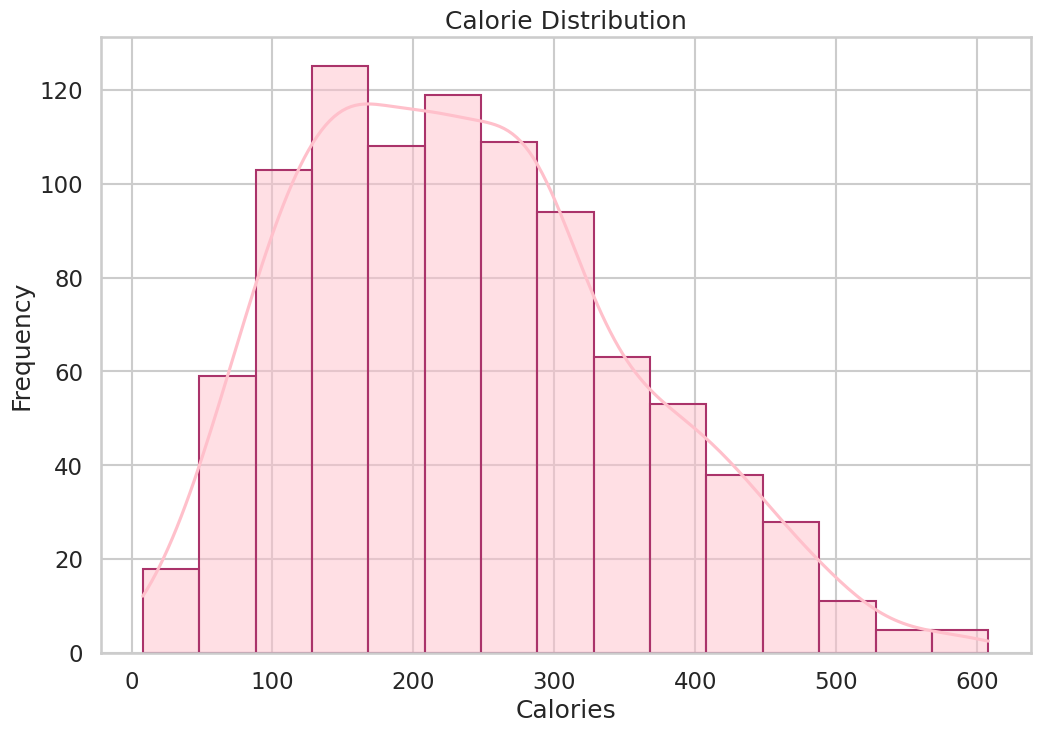

In [29]:
plt.figure(figsize=(12, 8))
sea.histplot(df['Calories'].dropna(), bins=15, kde=True, color= '#FFC0CB', edgecolor='#AA336A')
plt.title('Calorie Distribution')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

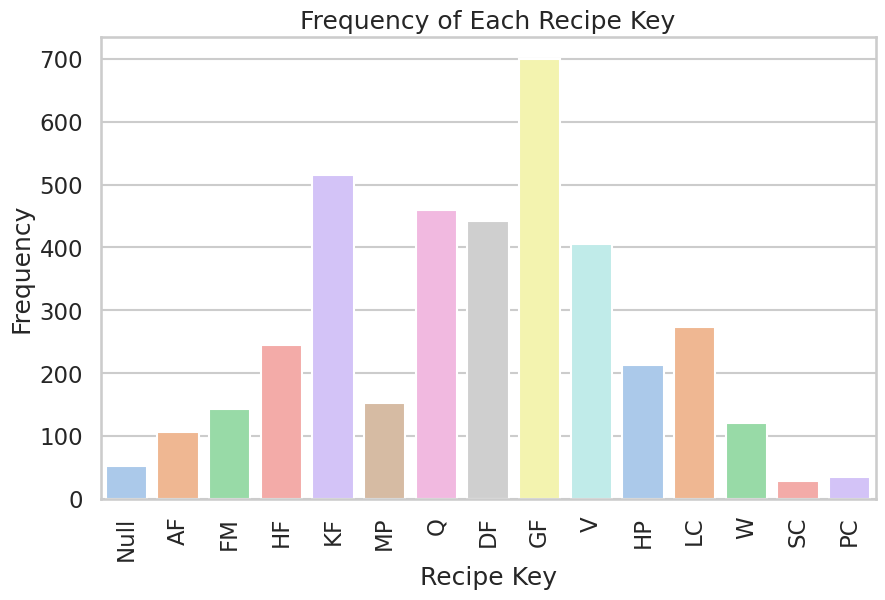

In [24]:
recipe_key_df = pd.DataFrame(list(recipe_key_count.items()), columns=['Recipe Key', 'Frequency'])

plt.figure(figsize=(10, 6))

sea.barplot(x='Recipe Key', y='Frequency', data=recipe_key_df, palette='pastel')

plt.title('Frequency of Each Recipe Key')
plt.xlabel('Recipe Key')
plt.ylabel('Frequency')

plt.xticks(rotation=90)

plt.show()

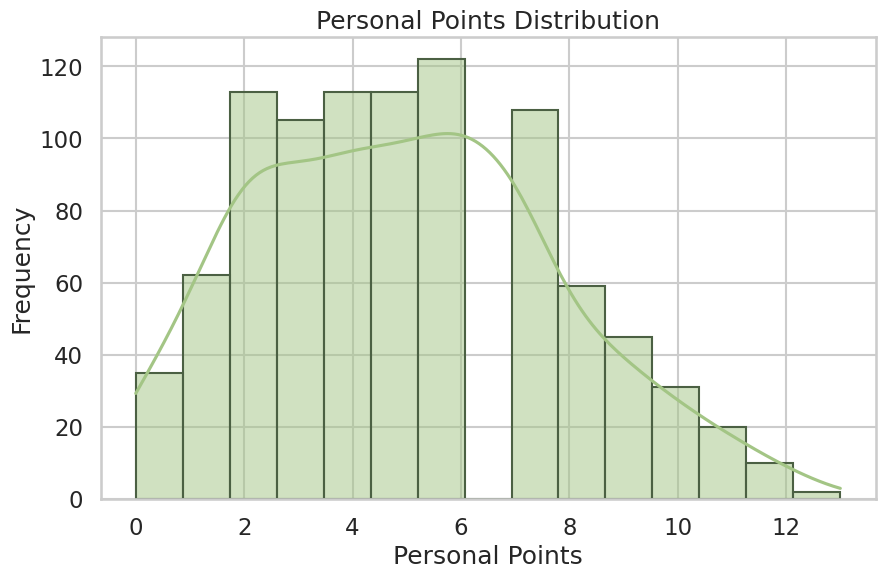

In [31]:
plt.figure(figsize=(10, 6))
sea.histplot(df['Personal Points'].dropna(), bins=15, kde=True, color= '#a3c585', edgecolor='#4B6043')
plt.title('Personal Points Distribution')
plt.xlabel('Personal Points')
plt.ylabel('Frequency')
plt.show()

In [27]:
def get_recipes(calorie_min, calorie_max, points_min, points_max):
    filtered_df = df[(df['Calories'] >= calorie_min) & (df['Calories'] <= calorie_max) &
                     (df['Personal Points'] >= points_min) & (df['Personal Points'] <= points_max)]
    sorted_df = filtered_df.sort_values(by='Calories').head(10)
    return sorted_df

calorie_min = int(input("Enter minimum calories:"))
calorie_max = int(input("Enter maximum calories:"))
points_min = int(input("Enter minimum personal points:"))
points_max = int(input("Enter maximum personal points:"))

recipes = get_recipes(calorie_min, calorie_max, points_min, points_max)
print("\n")
print("Top 10 recipes for you:")
for index, row in recipes.iterrows():
    print(f"Name: {row['Name']}")
    display(Image(url=row['Image']))
    print(f"Calories: {row['Calories']}")
    print(f"Summary: {row['Summary']}")
    print("\n")


Enter minimum calories:99
Enter maximum calories:180
Enter minimum personal points:1
Enter maximum personal points:7


Top 10 recipes for you:
Name: String Beans with Garlic and Oil


Calories: 99.0
Summary: This garlic green bean recipe is a quick, healthy side dish for all you garlic lovers.


Name: Mashed Sweet Potatoes Brulee


Calories: 100.0
Summary: Mashed Sweet Potatoes Brulee are seasoned with with a hint of cinnamon and nutmeg topped with a caramelized brown sugar crust.


Name: Caprese Salad


Calories: 100.0
Summary: Caprese Salad or Insalata Caprese is a simple summer salad with fresh mozzarella, thick slices of juicy tomatoes, basil and a splash of balsamic vinegar. Serve it as an appetizer, side dish, or just make it a meal!


Name: Grilled Pineapple


Calories: 102.0
Summary: This quick and easy Grilled Pineapple with honey, lime juice, and cinnamon is the perfect dessert for summer dinners or backyard parties!


Name: Asian Chicken Lettuce Wraps


Calories: 102.0
Summary: Quick and easy Asian Lettuce Wraps are delicious! Made with ground chicken, shiitake mushrooms, water chestnuts with a spicy hoisin sauce.


Name: Roasted Green Beans with Caramelized Onions


Calories: 102.0
Summary: This simple side dish of Roasted Green Beans with Caramelized Onions pairs wonderfully with Thanksgiving turkey or roasted chicken.


Name: Skillet Mexican Zucchini


Calories: 102.0
Summary: Skillet Mexican Zucchini is incredibly delicious with a little bit of a kick from the jalapeño topped with melted queso blanco. So easy and quick, a must try!


Name: Pumpkin Bread Recipe


Calories: 103.0
Summary: Warm your kitchen with the aroma of pumpkin spice by baking this healthy pumpkin bread, ideal for cool, cozy fall days.


Name: Strawberry Cheesecake Dip


Calories: 103.0
Summary: Strawberry Cheesecake Dip tastes just like cheesecake in dip form – perfect for serving with fresh fruit or graham crackers.


Name: Chocolate Pistachio Biscotti


Calories: 103.0
Summary: Chocolate Pistachio Biscotti are perfect for holiday baking or giving away to friends!


